#Project: Movie Reviews Classification (NLP)

This project classifies movie reviews as positive or negative using the IMDB dataset, which consists of 50,000 highly polarized movie reviews. The dataset is split evenly into 25,000 reviews for training and 25,000 for testing. We will employ deep learning algorithms to predict the sentiment of these reviews.

We would use 3 different models with different hyperparamenters:
- SimpleNeuralNet (our own model)
- DeepNeuralNet (our own model)
- DistilBERT (distilbert-base-uncased)

The result could be found below in this notebook and at wandb report: https://api.wandb.ai/links/e-v-zgurskaya/u4vehuno

## Libraries and data downloading

In [1]:
!pip install -qqq contractions transformers datasets evaluate accelerate wandb

In [2]:
import evaluate
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import random
import re
import seaborn as sns
import torch
import wandb

from bs4 import BeautifulSoup
from collections import Counter
from collections.abc import Collection
from contractions import fix
from datasets import load_dataset
from gensim.downloader import load
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
from wordcloud import WordCloud

In [3]:
# Load IMDB dataset using datasets library
imdb = load_dataset("imdb")

In [4]:
print({k: v.shape for k, v in imdb.items()})
print()
imdb["train"][0]

{'train': (25000, 2), 'test': (25000, 2), 'unsupervised': (50000, 2)}



{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

## Data preprocessing

Download the necessary NLTK data and the Word2Vec model to have essential resources for preprocessing and transforming text data into vectors, suitable for machine learning models

In [5]:
# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [6]:
# Initialize Word2Vec model
word2vec_model = load('word2vec-google-news-300')

Movie reviews will most likely use various abbreviations of phrases, here is a dictionary of most of popular chat abbreviations and acronyms that can make our IMDB preprocessing more comprehensive:

In [7]:
# a dictionary of the popular chat abbreviations and acronyms
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laughter",
    "TFW": "That Feeling When",
    "MFW": "My Face When",
    "MRW": "My Reaction When",
    "IFYP": "I Feel Your Pain",
    "TNTL": "Trying Not To Laugh",
    "JK": "Just Kidding",
    "IDC": "I Don’t Care",
    "ILY": "I Love You",
    "IMU": "I Miss You",
    "ADIH": "Another Day In Hell",
    "ZZZ": "Sleeping, Bored, Tired",
    "WYWH": "Wish You Were Here",
    "BAE": "Before Anyone Else",
    "FIMH": "Forever In My Heart",
    "BSAAW": "Big Smile And A Wink",
    "BWL": "Bursting With Laughter",
    "BFF": "Best Friends Forever",
    "CSL": "Can’t Stop Laughing",
    "AF": "As F***",
    "AIGHT": "Alright",
    "AMA": "Ask Me Anything",
    "BS": "Bullsh*t",
    "CBA": "Can't Be Arsed",
    "DM": "Direct Message",
    "DYK": "Did You Know",
    "ELI5": "Explain Like I'm 5",
    "FOMO": "Fear Of Missing Out",
    "FTFY": "Fixed That For You",
    "FTW": "For The Win",
    "FWB": "Friends With Benefits",
    "G2G": "Got To Go",
    "GTG": "Got To Go",
    "HBU": "How 'Bout You",
    "HIFW": "How I Feel When",
    "HMB": "Hit Me Back",
    "HMU": "Hit Me Up",
    "IDGAF": "I Don't Give A F***",
    "IDK": "I Don't Know",
    "IKR": "I Know, Right?",
    "ILYSM": "I Love You So Much",
    "IYKYK": "If You Know, You Know",
    "JFC": "Jesus F***ing Christ",
    "JOMO": "Joy Of Missing Out",
    "KYS": "Kill Yourself",
    "LMK": "Let Me Know",
    "LMFAO": "Laughing My F***ing A** Off",
    "LMS": "Like My Status",
    "NBD": "No Big Deal",
    "NGL": "Not Gonna Lie",
    "NSFW": "Not Safe For Work",
    "NVM": "Nevermind",
    "OFC": "Of Course",
    "OMW": "On My Way",
    "OMG": "Oh My God",
    "OOTD": "Outfit Of The Day",
    "POTD": "Post Of The Day",
    "RT": "Retweet",
    "SMH": "Shaking My Head",
    "TBH": "To Be Honest",
    "TBF": "To Be Fair",
    "TBT": "Throwback Thursday",
    "TIL": "Today I Learned",
    "TL;DR": "Too Long; Didn't Read",
    "WBU": "What About You",
    "WFH": "Work From Home",
    "YOLO": "You Only Live Once",
    "YMMV": "Your Mileage May Vary",
    "YAS": "Yes",
    "YASSS": "Yes",
    "YEET": "Throw"
}

In [8]:
# Count unique abbreviations
chat_words_lower = " ".join(chat_words.keys()).lower().split()
len(np.unique(chat_words_lower))

135

In [9]:
# Count the number of such abbreviations in the train and test datasets
def count_abbreviations(dataset_words):
  sum = 0
  for word in tqdm(chat_words_lower):
    sum += dataset_words.count(word)

  return sum


X_train_words = list((" ".join(imdb["train"]["text"]).lower().split()))
X_test_words = list((" ".join(imdb["test"]["text"]).lower().split()))

X_train_abbreviations_sum = count_abbreviations(X_train_words)
X_test_abbreviations_sum = count_abbreviations(X_test_words)

print()
print(f"Number of abbreviations in X_train = {X_train_abbreviations_sum}")
print(f"Number of abbreviations in X_test = {X_test_abbreviations_sum}")

  0%|          | 0/135 [00:00<?, ?it/s]

  0%|          | 0/135 [00:00<?, ?it/s]


Number of abbreviations in X_train = 248
Number of abbreviations in X_test = 244


In [10]:
# Define preprocessing functions
def replace_chat_words(text):
    for word, full_word in chat_words.items():
        word_lower = word.lower()
        full_word_lower = full_word.lower()
        text = re.sub(
            r'\b' + re.escape(word_lower) + r'\b', full_word_lower, text
            )
    return text

In [11]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [12]:
def preprocess_text(text):
    # Expand contractions
    text = fix(text)
    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # Handle negations
    text = re.sub(r"\b(?:not|n't)\b", " not", text)
    # Remove non-letter characters and convert to lowercase
    text = re.sub("[^a-zA-Z]", " ", text).lower()
    # Tokenize and remove stop words
    words = text.split()
    words = [word for word in words if word not in stop_words]
    # Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]
    # Remove words not in Word2Vec vocabulary
    words = [word for word in words if word in word2vec_model.key_to_index]
    return ' '.join(words)

In [13]:
# Preprocess IMDB dataset
def preprocess_function(examples):
    examples["text"] = [
        preprocess_text(replace_chat_words(text)) for text in examples["text"]
        ]
    return tokenizer(examples["text"], truncation=True, padding=True)

In [14]:
# Tokenizer for DistilBERT
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize only train and test splits
tokenized_imdb = {
    "train": imdb["train"].map(preprocess_function, batched=True),
    "test": imdb["test"].map(preprocess_function, batched=True)
}

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

<ipython-input-12-876767614fcb>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [15]:
tokenized_imdb["train"]["text"][0]

'rented curious yellow video store controversy surrounded first released also heard first seized custom ever tried enter country therefore fan film considered controversial really see plot centered around young swedish drama student named lena want learn everything life particular want focus attention making sort documentary average swede thought certain political issue vietnam war race issue united state asking politician ordinary denizen stockholm opinion politics sex drama teacher classmate married men kill curious yellow year ago considered pornographic really sex nudity scene far even shot like cheaply made porno countryman mind find shocking reality sex nudity major staple swedish cinema even arguably answer good old boy john ford sex scene film commend filmmaker fact sex shown film shown artistic purpose rather shock people make money shown pornographic theater america curious yellow good film anyone wanting study meat potato pun intended swedish cinema really film much plot'

In [16]:
# Data collator for DistilBERT
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define label mappings
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [17]:
# Evaluation metric
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy_metric.compute(predictions=predictions, references=labels)

In [18]:
# Create word embeddings for SimpleNN and DeepNN
def pad_or_trim_to_length(pad_length, vectors, pad_vector):
    vectors = vectors[:pad_length] + [pad_vector] * max(
        0, pad_length - len(vectors)
        )
    return np.stack(vectors)

def seq_to_emb(sentences, wv, pad_length, pad_token="</s>"):
    rv = []
    for sentence in sentences:
        sentence_embeddings = []
        for one_token in sentence.split():
            if wv.has_index_for(one_token):
                sentence_embeddings.append(wv.get_vector(one_token))
        sentence_embeddings = pad_or_trim_to_length(
            pad_length, sentence_embeddings, wv.get_vector(pad_token)
            )
        rv.append(np.stack(sentence_embeddings))
    return np.stack(rv)

In [19]:
# Function to enable deterministic results
def enable_determinism():
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    torch.use_deterministic_algorithms(True)

# Function to fix random seeds for reproducibility
def fix_seeds(seed: int):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.mps.manual_seed(seed)

# Seed worker function for DataLoader
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Generator for DataLoader
g = torch.Generator()
g.manual_seed(0)

enable_determinism()
fix_seeds(0)

In [20]:
# Custom Dataset class
class IMDBDataset(Dataset):
    def __init__(self, texts, labels, wv, pad_length):
        self.texts = texts
        self.labels = labels
        self.wv = wv
        self.pad_length = pad_length
        self.pad_token = "</s>"

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        embedding = seq_to_emb(
            [text], self.wv, self.pad_length, self.pad_token
            ).squeeze(0)
        return torch.tensor(
            embedding, dtype=torch.float32
            ), torch.tensor(
                label, dtype=torch.long
              )

In [21]:
# Convert tokenized texts back to strings
def tokens_to_texts(tokenized_texts):
    return [" ".join(
        tokenizer.convert_ids_to_tokens(tokens)
        ) for tokens in tokenized_texts]

X_train_texts = tokens_to_texts(tokenized_imdb["train"]["input_ids"])
X_test_texts = tokens_to_texts(tokenized_imdb["test"]["input_ids"])
y_train = tokenized_imdb["train"]["label"]
y_test = tokenized_imdb["test"]["label"]

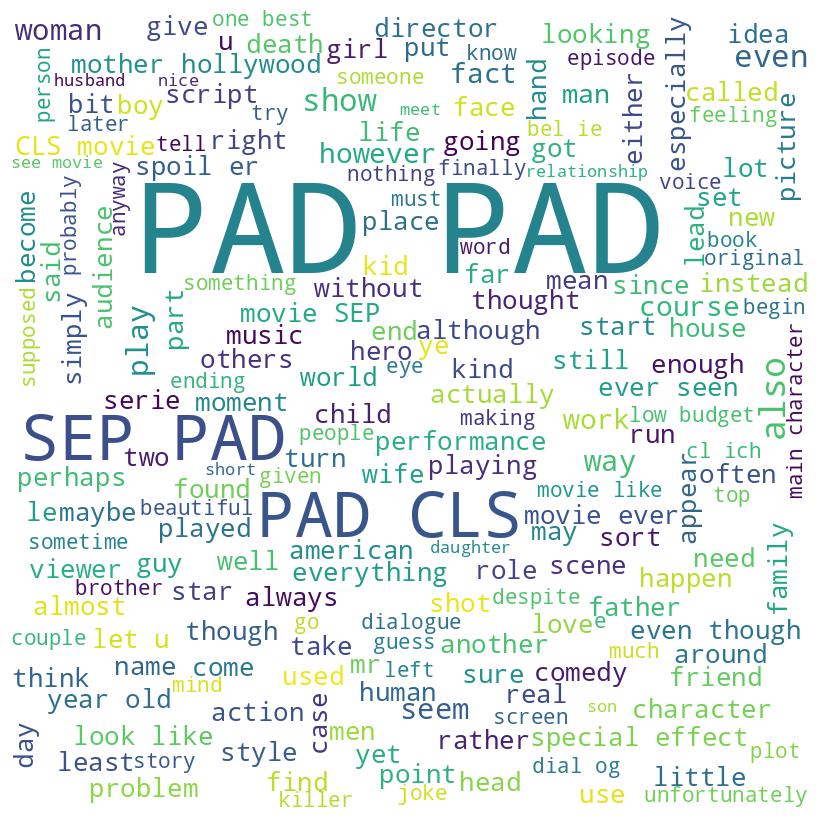

In [22]:
# the most common words after preprocessing in X_train_texts
def generate_word_cloud(texts):
    text = ' '.join(texts)
    wordcloud = WordCloud(width = 800, height = 800,
                          background_color ='white',
                          stopwords = stop_words,
                          min_font_size = 10).generate(text)

    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

generate_word_cloud(X_train_texts)

## Dataset / Dataloader creation

In [23]:
# Create datasets for SimpleNN and DeepNN
pad_length = 512
train_dataset = IMDBDataset(X_train_texts, y_train, word2vec_model, pad_length)
test_dataset = IMDBDataset(X_test_texts, y_test, word2vec_model, pad_length)

In [24]:
# Create data loaders for SimpleNN and DeepNN
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True,
    num_workers=2, worker_init_fn=seed_worker, generator=g
    )
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=2)

## Functions and classes for modelling

In [25]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [26]:
# Accuracy calculation function
def accuracy(preds, labels):
    preds = torch.round(torch.sigmoid(preds))
    correct = (preds == labels).float()
    acc = correct.sum() / len(correct)
    return acc

In [27]:
# Evaluation function
def evaluate(model, val_loader, loss_fn, device):
    model.eval()
    val_losses = []
    val_accs = []

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device).float()

            pred = model(x).squeeze()
            loss = loss_fn(pred, y)
            acc = accuracy(pred, y)

            val_losses.append(loss.item())
            val_accs.append(acc.item())

    val_loss = np.mean(val_losses)
    val_acc = np.mean(val_accs)
    return val_loss, val_acc

In [28]:
# Training loop function for SimpleNN and DeepNN
def train_loop(model: nn.Module, train_loader: DataLoader,
               val_loader: DataLoader, learning_rate = 1e-3, n_epochs = 10):

    fix_seeds(0)

    weight_decay = 1e-3
    ES_patience = 3
    scheduler_patience = 2
    delta = 0.01
    log_freq = 100

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    optimizer = optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
        )
    loss_fn = nn.BCEWithLogitsLoss()

    model.to(device).train()
    early_stopping = EarlyStopping(patience=ES_patience, delta=delta)

    wandb.watch(model, criterion=loss_fn, log="parameters", log_freq=log_freq)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=scheduler_patience,
        factor=0.5, verbose=True
        )

    val_losses = []
    val_accuracy = []

    for epoch in range(n_epochs):
        model.train()
        train_losses = []
        train_accs = []

        for i, (x, y) in tqdm(enumerate(train_loader),
                              total=len(train_loader),
                              desc=f"Epoch {epoch+1}/{n_epochs}"):
            x = x.to(device)
            y = y.to(device).float()

            optimizer.zero_grad()
            pred = model(x).squeeze()
            loss = loss_fn(pred, y)
            acc = accuracy(pred, y)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            train_accs.append(acc.item())

            if i % log_freq == 0:
                wandb.log({
                    "train_loss": loss.item(),
                    "train_acc": acc.item()
                })

        val_loss, val_acc = evaluate(model, val_loader, loss_fn, device)
        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}/{n_epochs}")
        print(f"""Train Loss: {np.mean(train_losses):.4f},
        Train Acc: {np.mean(train_accs):.4f}""")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        wandb.log({
            "epoch": epoch + 1,
            "val_loss": val_loss,
            "val_acc": val_acc
        })

        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(torch.load("checkpoint.pt"))
    return model, val_loss, val_acc

## Experiments with models

### SimpleNN

In [29]:
# simple model for baseline without Sigmoid layer as
# we are using nn.BCEWithLogitsLoss() for calculating the loss function,
# which includes the sigmoid activation internally
class SimpleNeuralNet(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNeuralNet, self).__init__()
        self.fc = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.fc(x)
        return out.squeeze()

In [30]:
# Initialize wandb and train the Simple Neural Network
wandb.init(project="Movie_Review", name="SimpleNN_lr1e-3")

# input_dim should match the embedding size
input_dim = pad_length * 300  # 300 is the dimension of word2vec embeddings

model = SimpleNeuralNet(input_dim=input_dim)
model_1, val_losses_1, val_accuracy_1 = train_loop(
    model, train_loader,test_loader, learning_rate=1e-3
    )
wandb.finish()

wandb: Currently logged in as: e-v-zgurskaya. Use `wandb login --relogin` to force relogin


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10
Train Loss: 0.5187, 
        Train Acc: 0.7557
Val Loss: 0.4947, Val Acc: 0.7676


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10
Train Loss: 0.2979, 
        Train Acc: 0.8938
Val Loss: 0.4652, Val Acc: 0.7872


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10
Train Loss: 0.2323, 
        Train Acc: 0.9294
Val Loss: 0.4596, Val Acc: 0.7911


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10
Train Loss: 0.1961, 
        Train Acc: 0.9495
Val Loss: 0.4701, Val Acc: 0.7849


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10
Train Loss: 0.1739, 
        Train Acc: 0.9599
Val Loss: 0.4782, Val Acc: 0.7848
Early stopping


epoch,▁▃▅▆█
train_acc,▁▅▅▅▇▇▇▆█▇▇▇██▇█▇▇█▇
train_loss,█▆▅▅▃▃▃▄▁▂▂▃▁▂▂▂▁▂▁▂
val_acc,▁▇█▆▆
val_loss,█▂▁▃▅
epoch,5
train_acc,0.9375
train_loss,0.18448
val_acc,0.78479
val_loss,0.47817


In [31]:
# change learning rate to 1e-4
wandb.init(project="Movie_Review", name="SimpleNN_lr1e-4")
model = SimpleNeuralNet(input_dim=input_dim)
model_2, val_losses_2, val_accuracy_2 = train_loop(
    model, train_loader, test_loader, learning_rate=1e-4
    )
wandb.finish()

Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10
Train Loss: 0.6354, 
        Train Acc: 0.7091
Val Loss: 0.5930, Val Acc: 0.7501


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10
Train Loss: 0.5272, 
        Train Acc: 0.8185
Val Loss: 0.5452, Val Acc: 0.7726


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10
Train Loss: 0.4661, 
        Train Acc: 0.8469
Val Loss: 0.5174, Val Acc: 0.7816


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10
Train Loss: 0.4235, 
        Train Acc: 0.8649
Val Loss: 0.4989, Val Acc: 0.7855


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10
Train Loss: 0.3911, 
        Train Acc: 0.8786
Val Loss: 0.4860, Val Acc: 0.7884


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10
Train Loss: 0.3650, 
        Train Acc: 0.8866
Val Loss: 0.4770, Val Acc: 0.7908


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10
Train Loss: 0.3431, 
        Train Acc: 0.8961
Val Loss: 0.4704, Val Acc: 0.7919


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10
Train Loss: 0.3250, 
        Train Acc: 0.9026
Val Loss: 0.4650, Val Acc: 0.7926


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10
Train Loss: 0.3088, 
        Train Acc: 0.9105
Val Loss: 0.4606, Val Acc: 0.7940


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10
Train Loss: 0.2942, 
        Train Acc: 0.9159
Val Loss: 0.4576, Val Acc: 0.7957


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▅▅▆▆▆▇▆▇▇▇▇█▇▇▇▆▇▇▇▇▇▇▇▇█▇█▇▇▇▇▇███▇▇▇
train_loss,█▇▇▇▆▆▅▅▅▅▄▄▃▃▃▃▃▄▄▃▃▃▃▃▂▂▂▃▂▂▃▃▂▂▂▁▂▂▂▂
val_acc,▁▄▆▆▇▇▇███
val_loss,█▆▄▃▂▂▂▁▁▁
epoch,10
train_acc,0.92188
train_loss,0.28858
val_acc,0.79568
val_loss,0.4576


In [32]:
# change learning rate to 1e-5
wandb.init(project="Movie_Review", name="SimpleNN_lr1e-5")
model = SimpleNeuralNet(input_dim=input_dim)
model_3, val_losses_3, val_accuracy_3 = train_loop(
    model, train_loader, test_loader, learning_rate=1e-5
    )
wandb.finish()

Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10
Train Loss: 0.6859, 
        Train Acc: 0.5842
Val Loss: 0.6791, Val Acc: 0.6316


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10
Train Loss: 0.6666, 
        Train Acc: 0.6996
Val Loss: 0.6662, Val Acc: 0.6978


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10
Train Loss: 0.6494, 
        Train Acc: 0.7626
Val Loss: 0.6542, Val Acc: 0.7155


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10
Train Loss: 0.6335, 
        Train Acc: 0.7788
Val Loss: 0.6433, Val Acc: 0.7329


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10
Train Loss: 0.6188, 
        Train Acc: 0.7926
Val Loss: 0.6335, Val Acc: 0.7426


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10
Train Loss: 0.6052, 
        Train Acc: 0.8031
Val Loss: 0.6241, Val Acc: 0.7417


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10
Train Loss: 0.5925, 
        Train Acc: 0.8104
Val Loss: 0.6155, Val Acc: 0.7453


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10
Train Loss: 0.5806, 
        Train Acc: 0.8155
Val Loss: 0.6074, Val Acc: 0.7508


Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10
Train Loss: 0.5693, 
        Train Acc: 0.8179
Val Loss: 0.6000, Val Acc: 0.7566


Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10
Train Loss: 0.5589, 
        Train Acc: 0.8251
Val Loss: 0.5931, Val Acc: 0.7560


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▃▂▁▄▄▅▃▄▅██▆▆▅▇▆▆▆▇▆▆▇▆▇▆▇▅▅▇▆▆▆▇▇▇▇▇▇▆▇
train_loss,███▇▇▆▇▆▆▆▅▅▅▆▅▅▅▅▄▅▄▃▄▄▃▂▄▄▃▄▃▁▃▂▂▂▁▁▂▁
val_acc,▁▅▆▇▇▇▇███
val_loss,█▇▆▅▄▄▃▂▂▁
epoch,10
train_acc,0.82812
train_loss,0.55002
val_acc,0.75602
val_loss,0.59313


### DeepNN

In [33]:
class DeepNeuralNet(nn.Module):

    def __init__(self, num_filters):
      super().__init__()
      emb_size = 300
      filter_sizes = [2, 3, 4]

      self.convs = nn.ModuleList([
          nn.Sequential(
              nn.Conv1d(emb_size, num_filters, kernel_size=filter_size),
              nn.BatchNorm1d(num_filters),
              nn.ReLU(),
              nn.Conv1d(num_filters, num_filters * 2, kernel_size=filter_size),
              nn.BatchNorm1d(num_filters * 2),
              nn.ReLU(),
              nn.Conv1d(num_filters * 2, num_filters, kernel_size=filter_size),
              nn.BatchNorm1d(num_filters),
              nn.ReLU(),
              nn.MaxPool1d(kernel_size=2)
              ) for filter_size in filter_sizes
          ])

      self.lstm = nn.LSTM(num_filters * len(filter_sizes), 128,
                          batch_first=True, dropout=0.5)

      self.fc = nn.Sequential(
          nn.Dropout(0.6),
          nn.Linear(128, 64),
          nn.ReLU(),
          nn.Dropout(0.6),
          nn.Linear(64, 32),
          nn.ReLU(),
          nn.Dropout(0.6),
          nn.Linear(32, 1),
          )

    def forward(self, x):

      x = x.permute(0, 2, 1)  # (batch_size, emb_size, seq_len)
      conv_outputs = [torch.max(conv(x), dim=2)[0] for conv in self.convs]
      x = torch.cat(conv_outputs, dim=1)

      x = x.unsqueeze(1)  # Adding an extra dimension for LSTM
      lstm_out, (hn, cn) = self.lstm(x)  # (batch_size, seq_len, hidden_size)
      x = hn[-1]  # Take the last hidden state

      x = self.fc(x).squeeze(1)
      return x

In [34]:
# Train the Deep Neural Network
wandb.init(project="Movie_Review", name="DeepNN_lr1e-4_filters_2")
model = DeepNeuralNet(num_filters=2)

model_4, val_losses_4, val_accuracy_4 = train_loop(
    model, train_loader, test_loader, learning_rate=1e-4
    )
wandb.finish()

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/10
Train Loss: 0.6932, 
        Train Acc: 0.5072
Val Loss: 0.6916, Val Acc: 0.5565


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10
Train Loss: 0.6507, 
        Train Acc: 0.6435
Val Loss: 0.5072, Val Acc: 0.7768


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10
Train Loss: 0.4871, 
        Train Acc: 0.7946
Val Loss: 0.4290, Val Acc: 0.8060


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10
Train Loss: 0.4387, 
        Train Acc: 0.8219
Val Loss: 0.4009, Val Acc: 0.8213


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10
Train Loss: 0.4095, 
        Train Acc: 0.8329
Val Loss: 0.3909, Val Acc: 0.8257


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10
Train Loss: 0.3966, 
        Train Acc: 0.8415
Val Loss: 0.3848, Val Acc: 0.8282


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10
Train Loss: 0.3810, 
        Train Acc: 0.8502
Val Loss: 0.3834, Val Acc: 0.8297


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10
Train Loss: 0.3670, 
        Train Acc: 0.8567
Val Loss: 0.3820, Val Acc: 0.8305
Early stopping


epoch,▁▂▃▄▅▆▇█
train_acc,▁▂▃▂▁▃▅▅▆▆▅▇▇▇▇▇█▇▇█▇▆█▇█▇▇▇█▇▇▇
train_loss,██████▇▇▅▄▅▃▄▄▄▃▂▃▄▂▃▆▂▃▂▃▂▃▁▄▂▂
val_acc,▁▇▇█████
val_loss,█▄▂▁▁▁▁▁
epoch,8
train_acc,0.89062
train_loss,0.28088
val_acc,0.83055
val_loss,0.38204


In [35]:
# num_filters = 4, lr = 1e-4
wandb.init(project="Movie_Review", name="DeepNN_lr1e-4_filters_4")
model = DeepNeuralNet(num_filters=4)

model_5, val_losses_5, val_accuracy_5 = train_loop(
    model, train_loader, test_loader, learning_rate=1e-4
    )
wandb.finish()

Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10
Train Loss: 0.6937, 
        Train Acc: 0.5019
Val Loss: 0.6920, Val Acc: 0.5905


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10
Train Loss: 0.6678, 
        Train Acc: 0.5962
Val Loss: 0.5288, Val Acc: 0.7906


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10
Train Loss: 0.4740, 
        Train Acc: 0.8061
Val Loss: 0.4102, Val Acc: 0.8184


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10
Train Loss: 0.4136, 
        Train Acc: 0.8368
Val Loss: 0.3934, Val Acc: 0.8250


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10
Train Loss: 0.3923, 
        Train Acc: 0.8510
Val Loss: 0.3821, Val Acc: 0.8302


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10
Train Loss: 0.3737, 
        Train Acc: 0.8601
Val Loss: 0.3803, Val Acc: 0.8333


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10
Train Loss: 0.3507, 
        Train Acc: 0.8703
Val Loss: 0.3773, Val Acc: 0.8335


Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10
Train Loss: 0.3389, 
        Train Acc: 0.8752
Val Loss: 0.3813, Val Acc: 0.8329
Early stopping


epoch,▁▂▃▄▅▆▇█
train_acc,▂▃▃▃▁▃▂▃▅▆▇▅█▇█▇▆▆▇▇▇▇▇████▇█▇▇█
train_loss,████████▆▇▄▇▃▂▁▃▅▄▅▄▄▄▄▂▂▁▁▃▂▆▄▂
val_acc,▁▇██████
val_loss,█▄▂▁▁▁▁▁
epoch,8
train_acc,0.9375
train_loss,0.25798
val_acc,0.83286
val_loss,0.38127


In [36]:
# lr = 1e-3
wandb.init(project="Movie_Review", name="DeepNN_lr1e-3_filters_4")
model = DeepNeuralNet(num_filters=4)

model_7, val_losses_7, val_accuracy_7 = train_loop(
    model, train_loader, test_loader, learning_rate=1e-3
    )
wandb.finish()

Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10
Train Loss: 0.5261, 
        Train Acc: 0.7235
Val Loss: 0.4024, Val Acc: 0.8174


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10
Train Loss: 0.3918, 
        Train Acc: 0.8394
Val Loss: 0.3585, Val Acc: 0.8381


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10
Train Loss: 0.3551, 
        Train Acc: 0.8570
Val Loss: 0.3428, Val Acc: 0.8507


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10
Train Loss: 0.3329, 
        Train Acc: 0.8696
Val Loss: 0.3490, Val Acc: 0.8497


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10
Train Loss: 0.3173, 
        Train Acc: 0.8768
Val Loss: 0.3558, Val Acc: 0.8437


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10
Train Loss: 0.2964, 
        Train Acc: 0.8869
Val Loss: 0.3477, Val Acc: 0.8522
Early stopping


epoch,▁▂▄▅▇█
train_acc,▁▃▆▆▅▆▆▆█▇▆▇▆▇▇▇▇▇▆▇▇▇▇▆
train_loss,██▅▄▆▃▄▃▁▃▃▃▃▂▂▂▁▂▃▄▃▁▃▄
val_acc,▁▅█▇▆█
val_loss,█▃▁▂▃▂
epoch,6
train_acc,0.82812
train_loss,0.43784
val_acc,0.85218
val_loss,0.34767


In [37]:
# lr = 5e-4
wandb.init(project="Movie_Review", name="DeepNN_lr5e-4_filters_4")
model = DeepNeuralNet(num_filters=4)

model_8, val_losses_8, val_accuracy_8 = train_loop(
    model, train_loader, test_loader, learning_rate=5e-4
    )
wandb.finish()

Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 1/10
Train Loss: 0.6102, 
        Train Acc: 0.6418
Val Loss: 0.4298, Val Acc: 0.8073


Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10
Train Loss: 0.4261, 
        Train Acc: 0.8217
Val Loss: 0.3824, Val Acc: 0.8296


Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10
Train Loss: 0.3803, 
        Train Acc: 0.8451
Val Loss: 0.3799, Val Acc: 0.8281


Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10
Train Loss: 0.3485, 
        Train Acc: 0.8615
Val Loss: 0.3637, Val Acc: 0.8410


Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10
Train Loss: 0.3226, 
        Train Acc: 0.8732
Val Loss: 0.3663, Val Acc: 0.8406


Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10
Train Loss: 0.3064, 
        Train Acc: 0.8804
Val Loss: 0.3743, Val Acc: 0.8387


Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10
Train Loss: 0.2896, 
        Train Acc: 0.8894
Val Loss: 0.3729, Val Acc: 0.8410
Early stopping


epoch,▁▂▃▅▆▇█
train_acc,▁▂▅▄▄▅▅▄▆▆▆▅▆▇▆▆▆▆▇▆▇▇▇▇█▇▇▅
train_loss,██▇▆▇▅▄▇▃▄▃▆▃▃▄▃▃▄▂▃▃▃▃▃▁▂▁▄
val_acc,▁▆▅████
val_loss,█▃▃▁▁▂▂
epoch,7
train_acc,0.79688
train_loss,0.43282
val_acc,0.84103
val_loss,0.37288


### DistilBERT

In [41]:
# Initialize DistilBERT model with label mappings
model_name = "distilbert-base-uncased"
distilbert_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

# Training DistilBERT
# a default learning rate is set to 5e-5
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=5e-5,
    logging_steps=500,
    save_steps=500,
    load_best_model_at_end=True,
    run_name="distilbert-base-uncased_lr5e-5",
    report_to="wandb"
)

trainer = Trainer(
    model=distilbert_model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

wandb.init(project="DistilBERT")
trainer.train()
wandb.finish()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


train/epoch,▁▅█
train/global_step,▁▅█
train/grad_norm,▃▁█
train/learning_rate,█▅▁
train/loss,█▃▁
train/epoch,0.48
train/global_step,1500
train/grad_norm,6.97209
train/learning_rate,4e-05
train/loss,0.3581


Epoch,Training Loss,Validation Loss,Accuracy
1,0.325400,0.345850,0.888520
2,0.222400,0.358324,0.896920
3,0.127900,0.461050,0.896640


eval/accuracy,▁██
eval/loss,▁▂█
eval/runtime,▁█▂
eval/samples_per_second,█▁▇
eval/steps_per_second,█▁▇
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▅▆▆▆▇▇▇███
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▅▆▆▆▇▇▇███
train/grad_norm,▄▂▃▆▃▂▁▃▃▁█▁▁▄▁▅▁▁
train/learning_rate,██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
train/loss,█▆▆▅▅▅▃▃▃▃▃▃▂▁▁▁▁▁
eval/accuracy,0.89664


In [43]:
# Initialize DistilBERT model with label mappings
model_name = "distilbert-base-uncased"
distilbert_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

# Training DistilBERT
# learning rate is set to 1e-5
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=1e-5,
    logging_steps=500,
    save_steps=500,
    load_best_model_at_end=True,
    run_name="distilbert-base-uncased_lr1e-5",
    report_to="wandb"
)

trainer = Trainer(
    model=distilbert_model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

wandb.init(project="DistilBERT")
trainer.train()
wandb.finish()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.311300,0.294153,0.897000
2,0.269900,0.322781,0.903480
3,0.186600,0.382622,0.905040


eval/accuracy,▁▇█
eval/loss,▁▃█
eval/runtime,█▇▁
eval/samples_per_second,▁▂█
eval/steps_per_second,▁▂█
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▅▆▆▆▇▇▇███
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▅▆▆▆▇▇▇███
train/grad_norm,▄▂▂▄▃▅▄▄█▁▇▅▇▁▁▁▁▃
train/learning_rate,██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
train/loss,█▆▆▅▅▄▄▃▃▃▃▃▂▂▂▁▂▁
eval/accuracy,0.90504


In [44]:
# Initialize DistilBERT model with label mappings
model_name = "distilbert-base-uncased"
distilbert_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

# Training DistilBERT
# learning rate is set to 1e-4
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=1e-4,
    logging_steps=500,
    save_steps=500,
    load_best_model_at_end=True,
    run_name="distilbert-base-uncased_lr1e-4",
    report_to="wandb"
)

trainer = Trainer(
    model=distilbert_model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

wandb.init(project="DistilBERT")
trainer.train()
wandb.finish()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.488900,0.453117,0.852520
2,0.368800,0.346072,0.868880
3,0.276700,0.367293,0.878320


eval/accuracy,▁▅█
eval/loss,█▁▂
eval/runtime,▇█▁
eval/samples_per_second,▂▁█
eval/steps_per_second,▂▁█
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▅▆▆▆▇▇▇███
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▅▆▆▆▇▇▇███
train/grad_norm,▂▃▄▂▂▂▂▂█▁▂▂▁▁▂▅▄▂
train/learning_rate,██▇▇▆▆▆▅▅▄▄▃▃▃▂▂▁▁
train/loss,█▇▇▆██▆▄▄▄▄▄▂▂▂▂▁▁
eval/accuracy,0.87832


In [45]:
# Initialize DistilBERT model with label mappings
model_name = "distilbert-base-uncased"
distilbert_model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

# Training DistilBERT
# learning rate is set to 1e-5 with 5 epochs
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    learning_rate=1e-5,
    logging_steps=500,
    save_steps=500,
    load_best_model_at_end=True,
    run_name="distilbert-base-uncased_lr1e-5_epoch5",
    report_to="wandb"
)

trainer = Trainer(
    model=distilbert_model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

wandb.init(project="DistilBERT")
trainer.train()
wandb.finish()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.313100,0.295199,0.896960
2,0.273500,0.326115,0.902840
3,0.194500,0.401973,0.902480
4,0.139800,0.450366,0.901680
5,0.094000,0.494493,0.903400


eval/accuracy,▁▇▇▆█
eval/loss,▁▂▅▆█
eval/runtime,▆▄▁█▆
eval/samples_per_second,▃▅█▁▃
eval/steps_per_second,▃▅█▁▃
train/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
train/grad_norm,▂▂▁▂▂▂▂▂▄▁▃▃▁▁▁▁▁▄▂▄█▆▁▁▃▁▁▁▁▁▃
train/learning_rate,███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
train/loss,█▆▆▆▆▅▅▄▄▅▅▅▃▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
eval/accuracy,0.9034


In [46]:
# collect the result into dictionary
results = {
    'SimpleNN_lr1e-3': {
        'val_loss': val_losses_1,
        'val_acc': val_accuracy_1
    },
    'SimpleNN_lr1e-4': {
        'val_loss': val_losses_2,
        'val_acc': val_accuracy_2
    },
    'SimpleNN_lr1e-5': {
        'val_loss': val_losses_3,
        'val_acc': val_accuracy_3
    },
    'DeepNN_lr1e-4_filters_2': {
        'val_loss': val_losses_4,
        'val_acc': val_accuracy_4
    },
    'DeepNN_lr1e-4_filters_4': {
        'val_loss': val_losses_5,
        'val_acc': val_accuracy_5
    },
    'DeepNN_lr1e-3_filters_4': {
        'val_loss': val_losses_7,
        'val_acc': val_accuracy_7
    },
    'DeepNN_lr5e-4_filters_4': {
        'val_loss': val_losses_8,
        'val_acc': val_accuracy_8
    },
    'DistilBERT_lr5e-5': {
        'val_loss': 0.461050,
        'val_acc': 0.896640
    },
    'DistilBERT_lr1e-5': {
        'val_loss': 0.382622,
        'val_acc': 0.905040
    },
    'DistilBERT_lr1e-4': {
        'val_loss': 0.367293,
        'val_acc': 0.878320
    },
    'DistilBERT_lr1e-5_epoch5': {
        'val_loss': 0.494493,
        'val_acc': 0.903400
    }
}

<ipython-input-50-52411e9101d5>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(final_epoch_loss.keys()), y=list(final_epoch_loss.values()), ax=axs[0], palette=loss_colors)
<ipython-input-50-52411e9101d5>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
<ipython-input-50-52411e9101d5>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(final_epoch_acc.keys()), y=list(final_epoch_acc.values()), ax=axs[1], palette=acc_colors)
<ipython-input-50-52411e9101d5>:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), 

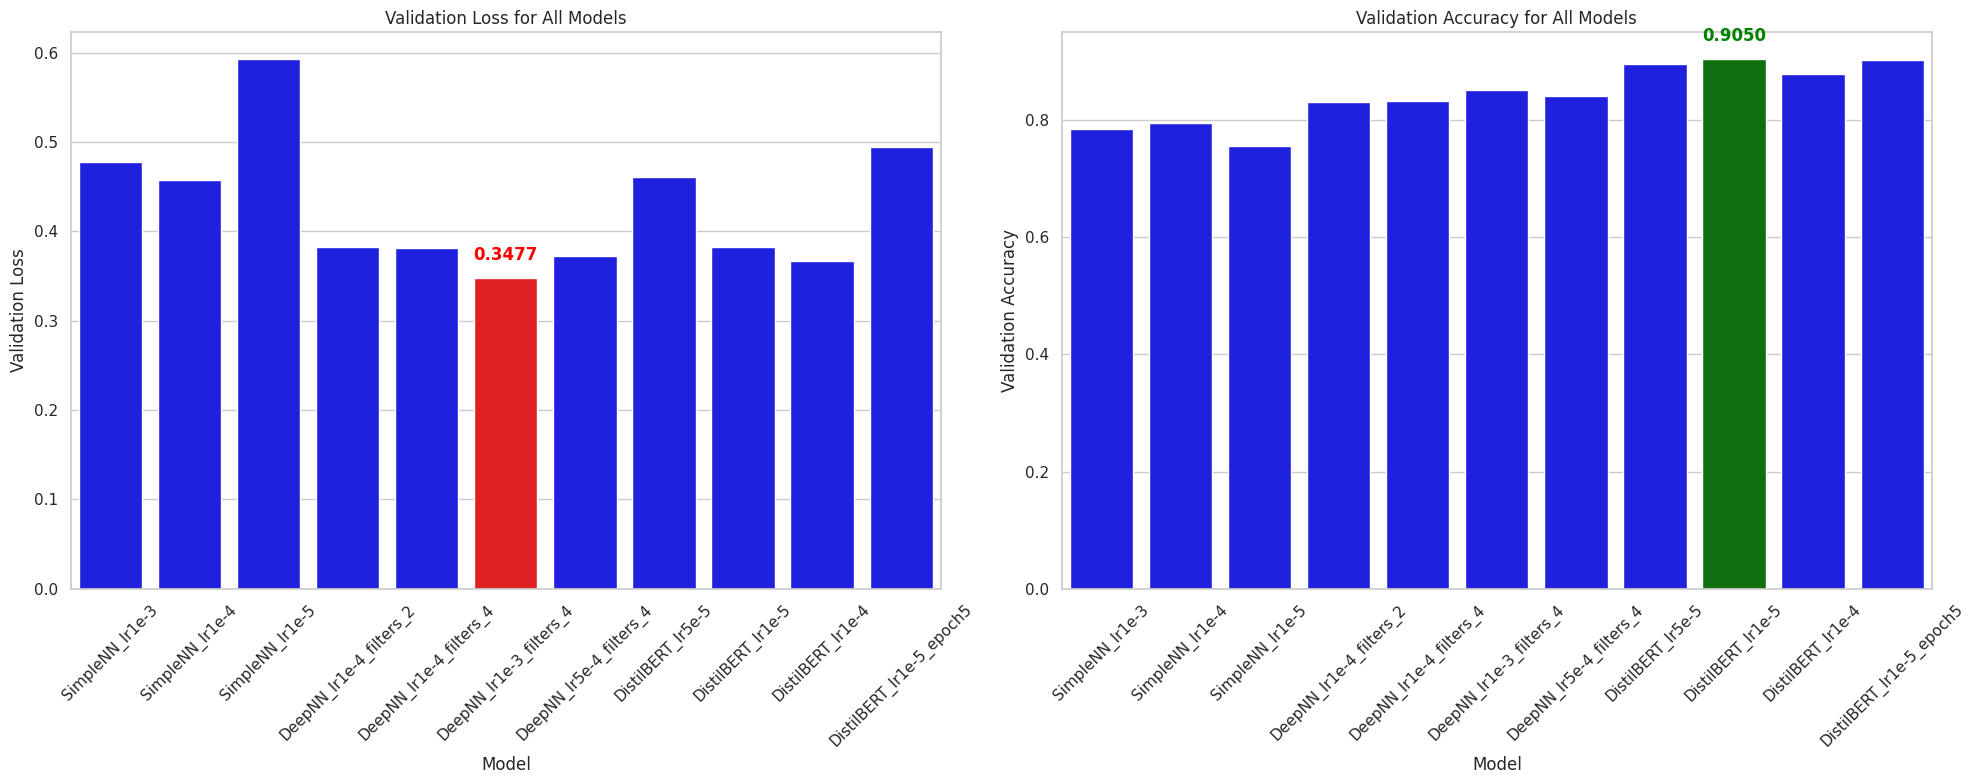

In [50]:
def plot_final_epoch_bar(results):
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(1, 2, figsize=(20, 8))

    final_epoch_loss = {model: res['val_loss'] for model, res in results.items() if res['val_loss']}
    final_epoch_acc = {model: res['val_acc'] for model, res in results.items() if res['val_acc']}

    min_loss_model = min(final_epoch_loss, key=final_epoch_loss.get)
    max_acc_model = max(final_epoch_acc, key=final_epoch_acc.get)

    loss_colors = ['red' if model == min_loss_model else 'blue' for model in final_epoch_loss.keys()]
    acc_colors = ['green' if model == max_acc_model else 'blue' for model in final_epoch_acc.keys()]

    # Plot for validation loss
    sns.barplot(x=list(final_epoch_loss.keys()), y=list(final_epoch_loss.values()), ax=axs[0], palette=loss_colors)
    axs[0].set_title('Validation Loss for All Models')
    axs[0].set_xlabel('Model')
    axs[0].set_ylabel('Validation Loss')
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)
    # Annotate min loss value
    min_loss_value = final_epoch_loss[min_loss_model]
    axs[0].annotate(f'{min_loss_value:.4f}', xy=(list(final_epoch_loss.keys()).index(min_loss_model), min_loss_value),
                    xytext=(0, 10), textcoords='offset points', ha='center', va='bottom', color='red', fontweight='bold')

    # Plot for validation accuracy
    sns.barplot(x=list(final_epoch_acc.keys()), y=list(final_epoch_acc.values()), ax=axs[1], palette=acc_colors)
    axs[1].set_title('Validation Accuracy for All Models')
    axs[1].set_xlabel('Model')
    axs[1].set_ylabel('Validation Accuracy')
    axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)
    # Annotate max accuracy value
    max_acc_value = final_epoch_acc[max_acc_model]
    axs[1].annotate(f'{max_acc_value:.4f}', xy=(list(final_epoch_acc.keys()).index(max_acc_model), max_acc_value),
                    xytext=(0, 10), textcoords='offset points', ha='center', va='bottom', color='green', fontweight='bold')

    plt.tight_layout()
    plt.show()

plot_final_epoch_bar(results)

## Conclusion

All three models showed good results of accuracy:
- SimpleNN_lr1e-4 = 0.7957
- DeepNN_lr1e-3_filters_4 = 0.8522
- distilbert-base-uncased_lr1e-5 = 0.9050

So the best model is DistilBERT with learning rate 1e-5 showed the best accuracy = 0.9050 at the third epoch.